In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv("frg_norm_hssm.csv")
trial_time = 3
stress_dict = {1:'pre',2:'post'}
tt_dict = {5:'short',20:'long'}
leave_resp_filt = df["response"]==0

In [94]:
def cum_rew_func(df,subid,stress_cond,tt_cond,ax,c):
    subid_filt = df["subj_idx"]==subid
    stress_filt = df["condition"]==stress_cond
    tt_filt = df["travel_time"]==tt_cond
    patch_leave_idx = pd.Index(df[subid_filt & stress_filt & tt_filt & leave_resp_filt].index)
    patch_entry_idx = pd.Index([df[subid_filt & stress_filt & tt_filt].index[0]]+list(patch_leave_idx+1))
    patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
#     rel_patch_trial_idx = [np.array(i)-i[0] for i in patch_trial_idx]
    rel_leave_idxs = list(patch_leave_idx - patch_entry_idx[0])

##    for idxs in patch_trial_idx:
##        patch_num = patch_trial_idx.index(idxs)
##        if len(df.loc[idxs]["travel_time"].unique())>1:
##            patch_trial_idx.remove(idxs)

    env_cum_rew = []
    patch_cum_rew = []
    for idxs in patch_trial_idx:
        patch_num = patch_trial_idx.index(idxs)
        tot_rew = np.array(df.loc[idxs][:]["tot_reward"])
        patch_rew = tot_rew-tot_rew[0]
        env_cum_rew+=list(tot_rew)
        patch_cum_rew.append(patch_rew)

    x_data = np.array([trial_time]*len(env_cum_rew))
    x_data[np.array(rel_leave_idxs)] = tt_cond; x_data[0]=0; x_data = np.cumsum(x_data)
    env_cum_rew = np.array(env_cum_rew)
    y_data = env_cum_rew-env_cum_rew[0]
    reg = LinearRegression(fit_intercept=False).fit(x_data.reshape(-1,1),y_data.reshape(-1,1))
    slope = reg.coef_; slope = slope.flatten()
    
    long_patch_len = max([len(i) for i in patch_cum_rew])
    num_patches = len(patch_cum_rew)
    patch_len = [len(i) for i in patch_cum_rew]
    
    stay_lock_patch_rew = np.nan*np.ones((num_patches,long_patch_len))

    for i in range(num_patches):
        stay_lock_patch_rew[i] = list(patch_cum_rew[i])+(long_patch_len-len(patch_cum_rew[i]))*[np.nan]
    
    mean_rew = np.nanmean(stay_lock_patch_rew,0)
    popt,pcov = [],[]
    try:
        popt, pcov = curve_fit(neg_exp_resp, x_data[:len(mean_rew)],mean_rew)
        ax.plot(x_data[:len(mean_rew)],neg_exp_resp(x_data[:len(mean_rew)],*popt),'-'+c)
    except RuntimeError:
        pass
    ax.plot(x_data,x_data*slope,'--'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
#     ax.plot(x_data,y_data,'-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))
#     ax.plot(x_data[:min(patch_len)-1],pre_mean_rew[:min(patch_len)-1],'.-'+c)
#     ax.plot(x_data[:len(mean_rew)],mean_rew[:],'.-'+c)
    ax.legend()
    return env_cum_rew,patch_cum_rew,popt,ax

[array([0.        , 0.00793763, 0.01411262, 0.01976883, 0.02450648,
        0.02841786, 0.02841786]),
 array([0.        , 0.01779212, 0.03492953, 0.05162867, 0.06728238,
        0.08174426, 0.09406341, 0.10489936, 0.11355657, 0.11355657]),
 array([0.        , 0.01873798, 0.03550079, 0.05053137, 0.06334856,
        0.07503873, 0.08474094, 0.08474094]),
 array([0.        , 0.01835967, 0.03547053, 0.05096115, 0.06517561,
        0.07880983, 0.09064375, 0.10177073, 0.11248823, 0.1213094 ,
        0.1286828 , 0.1286828 ])]

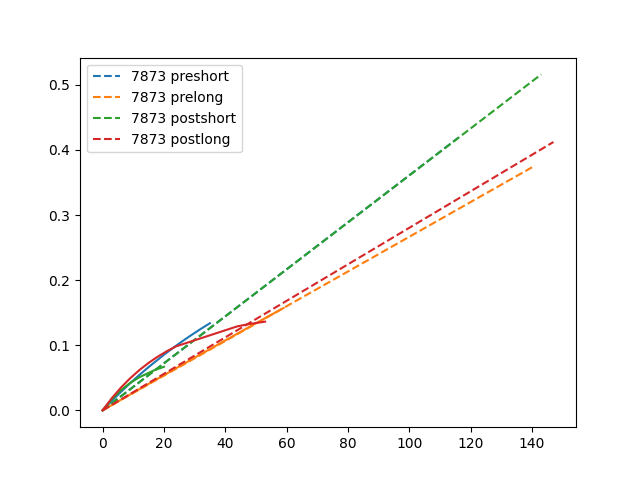

In [111]:
fig,ax=plt.subplots()

cum_rew_func_params = []

subid = 7873;

stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C0'); cum_rew_func_params.append(opt_params)
stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C1'); cum_rew_func_params.append(opt_params)
stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C2'); cum_rew_func_params.append(opt_params)
stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C3'); cum_rew_func_params.append(opt_params)

# subid = 15089;
# 
# stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C4'); cum_rew_func_params.append(opt_params)
# stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C5'); cum_rew_func_params.append(opt_params)
# stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C6'); cum_rew_func_params.append(opt_params)
# stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C7'); cum_rew_func_params.append(opt_params)

# subid = 45194;

# stress = 1; tt = 5;  preshort_env_rew,  preshort_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C8'); cum_rew_func_params.append(opt_params)
# stress = 1; tt = 20; prelong_env_rew,   prelong_patch_rew,   opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C9'); cum_rew_func_params.append(opt_params)
# stress = 2; tt = 5;  postshort_env_rew, postshort_patch_rew, opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C10'); cum_rew_func_params.append(opt_params)
# stress = 2; tt = 20; postlong_env_rew,  postlong_patch_rew,  opt_params, ax = cum_rew_func(df,subid,stress,tt,ax,'C11'); cum_rew_func_params.append(opt_params)

preshort_patch_rew
# np.mean([[preshort_patch_rew],[prelong_patch_rew],[postshort_patch_rew],[postlong_patch_rew]],0)

In [86]:
##Sections for testing:

subid = 45194; 

stress_cond = 2; tt_cond = 5; c='C0'

subid_filt = df["subj_idx"]==subid
stress_filt = df["condition"]==stress_cond
tt_filt = df["travel_time"]==tt_cond
patch_leave_idx = pd.Index(df[subid_filt & stress_filt & tt_filt & leave_resp_filt].index)
patch_entry_idx = pd.Index([df[subid_filt & stress_filt & tt_filt].index[0]]+list(patch_leave_idx+1))
patch_trial_idx = [list(range(i,j+1)) for (i,j) in list(zip(patch_entry_idx,patch_leave_idx))]
# rel_patch_trial_idx = [np.array(i)-i[0] for i in patch_trial_idx]
rel_leave_idxs = list(patch_leave_idx - patch_entry_idx[0])
patch_trial_idx

##    for idxs in patch_trial_idx:
##        patch_num = patch_trial_idx.index(idxs)
##        if len(df.loc[idxs]["travel_time"].unique())>1:
##            patch_trial_idx.remove(idxs)

[[76, 77],
 [78, 79, 80, 81],
 [82],
 [83, 84],
 [85, 86, 87],
 [88, 89, 90, 91],
 [92],
 [93, 94, 95],
 [96, 97, 98, 99, 100, 101]]

26
26
[0.         0.         0.03519911 0.0703132  0.10252796 0.10252796
 0.10252796 0.13653127 0.13653127 0.16995997 0.19864652 0.19864652
 0.23256785 0.26196549 0.28857873 0.28857873 0.28857873 0.32270596
 0.35098197 0.35098197 0.38528318 0.41724586 0.44843753 0.47836011
 0.50587331 0.50587331]


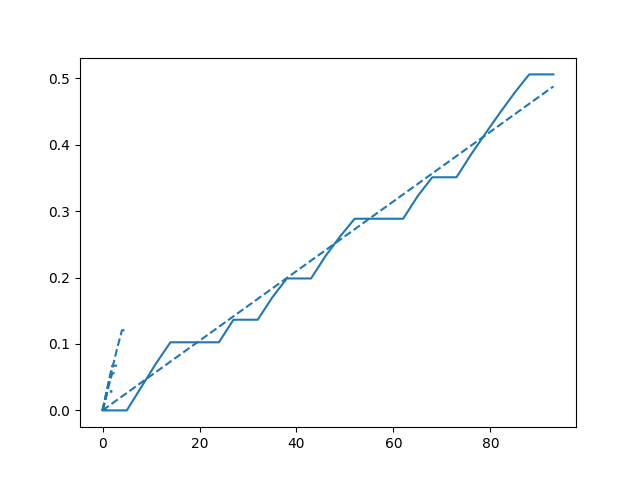

In [87]:
fig,ax=plt.subplots()

env_cum_rew = []
patch_cum_rew = []
for idxs in patch_trial_idx:
    patch_num = patch_trial_idx.index(idxs)
    tot_rew = np.array(df.loc[idxs][:]["tot_reward"])
    patch_rew = tot_rew-tot_rew[0]
    env_cum_rew+=list(tot_rew)
    patch_cum_rew.append(patch_rew)
    ax.plot(range(len(idxs)-0),patch_rew,'--'+c)#,label="Patch {}".format(patch_num))

x_data = np.array([trial_time]*len(env_cum_rew))
x_data[np.array(rel_leave_idxs)] = tt_cond
x_data[0]=0
print(len(x_data))
# print(len(env_cum_rew))
x_data = np.cumsum(list(x_data))
print(len(x_data))

env_cum_rew = np.array(env_cum_rew)
y_data = env_cum_rew-env_cum_rew[0]
# y_data = np.array([0]+list(y_data))
print(y_data)

reg = LinearRegression(fit_intercept=False).fit(x_data.reshape(-1,1),y_data.reshape(-1,1))
slope = reg.coef_; slope = slope.flatten()

ax.plot(x_data,x_data*slope,'--'+c)
ax.plot(x_data,y_data,'-'+c,label=str(subid)+' '+str(stress_dict[stress_cond])+str(tt_dict[tt_cond]))

In [88]:
long_patch_len = max([len(i) for i in patch_cum_rew])
num_patches = len(patch_cum_rew)
patch_len = [len(i) for i in patch_cum_rew]
# print(num_patches,long_patch_len)

stay_lock_patch_rew = np.nan*np.ones((num_patches,long_patch_len))
# idxs = [0]+list(np.cumsum(patch_len))

#stay_lock
for i in range(num_patches):
#     stay_lock_env_rew[i] = list(env_cum_rew[range(idxs[i],idxs[i+1])])+(long_patch_len-len(env_cum_rew[range(idxs[i],idxs[i+1])]))*[np.nan]
    stay_lock_patch_rew[i] = list(patch_cum_rew[i])+(long_patch_len-len(patch_cum_rew[i]))*[np.nan]

mean_rew = np.nanmean(stay_lock_patch_rew,0)
print(mean_rew)
ax.plot(x_data[:len(mean_rew)],mean_rew[:],'.-C1')

def neg_exp_resp(x,a,b):
    return a*(1-np.exp(-b*x))

popt, pcov = curve_fit(neg_exp_resp, x_data[:len(mean_rew)], mean_rew)
print(popt)
ax.plot(x_data[:len(mean_rew)],neg_exp_resp(x_data[:len(mean_rew)],*popt))

[0.         0.02191957 0.04869133 0.07213888 0.12059012 0.12059012]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [ ]:
{15089:[0.10924529 0.05928262],7873:[0.31503466 0.01579931],45194:[0.10848179 0.07480621]}
{15089:[0.24945322 0.02391265],7873:[0.08663458 0.07391452],45194:[0.10848179 0.07480621]}